# GP algorithm

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from deap import base, creator, algorithms, tools

In [ ]:
# --- DỮ LIỆU ---
iris = load_iris()
X = StandardScaler().fit_transform(iris.data)
y = iris.target
y = (y == 0).astype(int)  # nhị phân hóa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# --- ĐỊNH NGHĨA THÀNH PHẦN KIẾN TRÚC CÓ THỂ TIẾN HÓA ---
layer_options = ["Dense(16)", "Dense(32)", "Dense(64)"]
activation_options = ["ReLU", "Sigmoid", "Tanh"]
building_blocks = layer_options + activation_options

In [ ]:
# --- MAPPING CÁC THÀNH PHẦN KIẾN TRÚC ---
def build_model_from_genome(genome):
    layers = []
    input_dim = 4
    for gene in genome:
        if gene.startswith("Dense"):
            out_dim = int(gene.split("(")[1][:-1])
            layers.append(nn.Linear(input_dim, out_dim))
            input_dim = out_dim
        elif gene == "ReLU":
            layers.append(nn.ReLU())
        elif gene == "Sigmoid":
            layers.append(nn.Sigmoid())
        elif gene == "Tanh":
            layers.append(nn.Tanh())
    # output layer
    layers.append(nn.Linear(input_dim, 1))
    layers.append(nn.Sigmoid())  # binary classification
    return nn.Sequential(*layers)

In [ ]:
# --- FITNESS FUNCTION ---
def eval_nn(individual):
    model = build_model_from_genome(individual)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    # train trong 10 epochs
    try:
        for epoch in range(10):
            model.train()
            optimizer.zero_grad()
            output = model(X_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()

        # evaluate
        model.eval()
        with torch.no_grad():
            pred = (model(X_test) > 0.5).float()
            acc = (pred == y_test).float().mean().item()
        return acc,
    except Exception:
        return 0.0,  # nếu model lỗi thì return fitness = 0

In [ ]:
# --- GP SETUP ---
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("gene", lambda: random.choice(building_blocks))
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.gene, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_nn)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# --- CHẠY EVOLUTION ---
def run_gp_nn_search():
    random.seed(42)
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=10, stats=stats, halloffame=hof, verbose=True)

    print("\nBest Architecture:", hof[0])
    print("Best Accuracy:", hof[0].fitness.values[0])




In [ ]:
run_gp_nn_search()

gen	nevals	avg     	max
0  	10    	0.788889	1  
1  	5     	1       	1  
2  	7     	1       	1  
3  	9     	0.997778	1  
4  	5     	1       	1  
5  	6     	0.991111	1  
6  	6     	1       	1  
7  	3     	1       	1  
8  	10    	1       	1  
9  	8     	1       	1  
10 	7     	1       	1  

Best Architecture: ['Tanh', 'Dense(16)', 'Dense(16)', 'Tanh']
Best Accuracy: 1.0


# Iris Classification

In [ ]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load data & tiền xử lý
data = load_iris()
X = data['data']
y = data['target']
y_bin = (y == 0).astype(int)  # chỉ phân biệt Setosa (1) và Others (0)

X = StandardScaler().fit_transform(X)  # chuẩn hóa
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

In [ ]:
# Thiết lập GP Primitive Set
pset = gp.PrimitiveSet("MAIN", arity=4)  # 4 input features
pset.renameArguments(ARG0='x0', ARG1='x1', ARG2='x2', ARG3='x3')
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(max, 2)
pset.addPrimitive(min, 2)
pset.addEphemeralConstant("rand", lambda: random.uniform(-1, 1))

/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [ ]:
# Định nghĩa fitness và individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize accuracy
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("compile", gp.compile, pset=pset)

In [ ]:
# Fitness function
def eval_classifier(individual):
    func = toolbox.compile(expr=individual)
    try:
        pred = [1 if func(*x) > 0 else 0 for x in X_train]
        acc = accuracy_score(y_train, pred)
        return acc,
    except Exception:
        return 0.0,

In [ ]:
toolbox.register("evaluate", eval_classifier)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_init, pset=pset)

# Giới hạn độ sâu cây
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

In [ ]:
# Chạy tiến hóa
def run_gp_classification():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                                    ngen=20, stats=stats, halloffame=hof, verbose=True)

    # Đánh giá mô hình tốt nhất trên test set
    best = hof[0]
    func = toolbox.compile(expr=best)
    y_pred = [1 if func(*x) > 0 else 0 for x in X_test]
    acc_test = accuracy_score(y_test, y_pred)
    print("\nBest Expression:", best)
    print("Test Accuracy:", acc_test)


In [ ]:
if __name__ == "__main__":
    run_gp_classification()


gen	nevals	avg     	max
0  	50    	0.394667	1  
1  	31    	0.577714	0.933333
2  	37    	0.690476	0.980952
3  	38    	0.751429	0.990476
4  	31    	0.799238	0.990476
5  	31    	0.883619	1       
6  	31    	0.897524	1       
7  	30    	0.924571	1       
8  	30    	0.901143	1       
9  	32    	0.888571	1       
10 	32    	0.908381	1       
11 	33    	0.868571	1       
12 	31    	0.882476	1       
13 	29    	0.915619	1       
14 	31    	0.915619	1       
15 	42    	0.82419 	1       
16 	19    	0.942857	1       
17 	34    	0.891619	1       
18 	16    	0.965333	1       
19 	22    	0.935048	1       
20 	34    	0.866667	1       

Best Expression: neg(add(x3, 0.3191941467180819))
Test Accuracy: 1.0


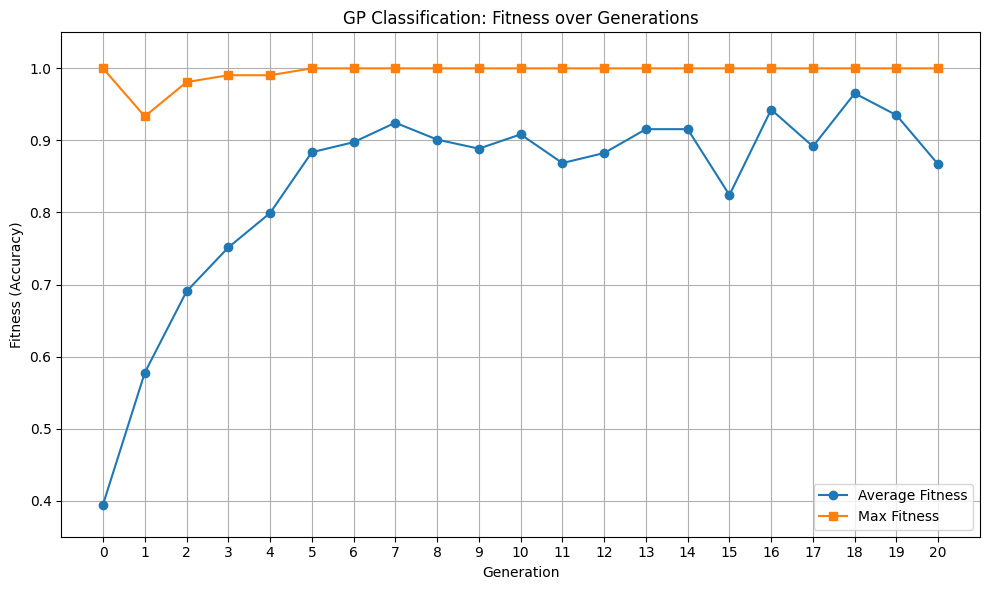

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ kết quả log
generations = list(range(21))
avg_fitness = [
    0.394667, 0.577714, 0.690476, 0.751429, 0.799238,
    0.883619, 0.897524, 0.924571, 0.901143, 0.888571,
    0.908381, 0.868571, 0.882476, 0.915619, 0.915619,
    0.82419,  0.942857, 0.891619, 0.965333, 0.935048,
    0.866667
]
max_fitness = [
    1, 0.933333, 0.980952, 0.990476, 0.990476,
    1, 1, 1, 1, 1,
    1, 1, 1, 1, 1,
    1, 1, 1, 1, 1,
    1
]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(generations, avg_fitness, marker='o', label='Average Fitness')
plt.plot(generations, max_fitness, marker='s', label='Max Fitness')
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("GP Classification: Fitness over Generations")
plt.xticks(generations)
plt.ylim(0.35, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
